<a href="https://colab.research.google.com/github/freha-mezzoudj/NLP_US_Airlines_tweets/blob/main/ML_Algorithms_US_Airlines_3Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **US Airlines Tweets Sentiment 3_Classes_Naive Bayes **

### **1. Problem Statement & approachs**

* Build a dictionary based on your training corpus. Calculate conditional probability of each token for each class (this is also called unigram probability). Then evaluate on test data and report accuracy.
* Try to improve your algorithm. Some suggestions: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;i. Remove STOP words from the vocabulary that appear vary frequently but not related to the attitude or opinion of the writer. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ii. Reduce the size of your vocabulary further by taking only top-k frequent word types that appear in the training dataset. Vary k and compare performance.

### **2. Importing Libraries & Loading Data**

In [3]:
#importing the required libraries & packages
import pandas as pd
import numpy as np
import time
import argparse
import string
from sklearn.model_selection import train_test_split
from nltk.tokenize import regexp_tokenize
from datetime import datetime
import pytz

import seaborn as sns
import re, nltk
nltk.download('punkt')
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
!pip install lime
from lime import lime_tabular
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 644 kB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=b7194cfb5569a058707744cc26db4f2fa92ec3eff9d1610c31bb86114b836a66
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [30]:
from google.colab import drive

In [31]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import os
os.chdir("/content/drive/My Drive/data")

In [33]:
#loading the US Airline Sentiment data
df =pd.read_csv('Tweets2.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [14]:
#df.shape

(14640, 15)

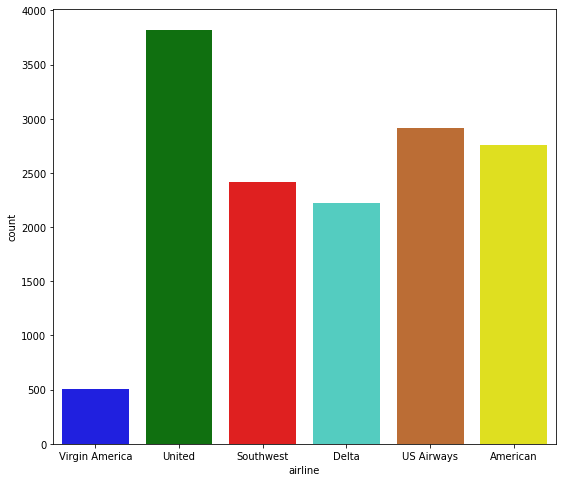

In [35]:
# Unique values of airline

col = ['blue', 'green', 'red', 'turquoise', 'chocolate', 'yellow']
plt.figure(figsize=(9,8))
ax = sns.countplot(x="airline", data=df, palette = col)

### **3. Tweets Preprocessing**

Basic Text Pre-Processing

Text preprocessing steps include a few essential tasks to further clean the available text data. It includes tasks like:-

Stop-Word Removal : In English words like a, an, the, as, in, on, etc. are considered as stop-words so according to our requirements we can remove them to reduce vocabulary size as these words don't have some specific meaning

Lower Casing : Convert all words into the lower case because the upper or lower case may not make a difference for the problem. And we are reducing vocabulary size by doing so.

Stemming : Stemming refers to the process of removing suffixes and reducing a word to some base form such that all different variants of that word can be represented by the same form (e.g., “walk” and “walking” are both reduced to “walk”).

Tokenization : NLP software typically analyzes text by breaking it up into words (tokens) and sentences

In [36]:
# I am tokenizing the tweet and also taking tokens from second index onwards as initital 
# to gives airline name and '@' and lowering them and later making it back a sentence
def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[2:])

                 

def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])


 
def check_scores(clf,X_train, X_test, y_train, y_test):

  model=clf.fit(X_train, y_train)
  predicted_class=model.predict(X_test)
  predicted_class_train=model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)


  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))

  print()
  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()
  print(classification_report(y_test,predicted_class)) 
  print() 
  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()
  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print("Train ROC-AUC score: ", train_auc)
  print("Test ROC-AUC score: ", test_auc)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(lr_recall, lr_precision, color = 'orange')
  ax1.set(xlabel="Recall", ylabel="Precision")

  plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  print()
  print('Are under Precision-Recall curve:', lr_f1)
  
  fpr, tpr, _ = roc_curve(y_test, test_probs)


  ax2.plot(fpr, tpr, color='mediumblue')
  ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

  print("Area under ROC-AUC:", lr_auc)
  return train_accuracy, test_accuracy, train_auc, test_auc



def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  print()
  print()
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model


Text Preparation ....

In [37]:
# removing neutral tweets

df = df[df['airline_sentiment']!='neutral']
df['cleaned_tweet'] = df['text'].apply(clean_the_tweet)

df.head()
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),you ve added commercials to the experience tacky
3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),s really aggressive to blast obnoxious enterta...
4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),it s a really big bad thing about it
5,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),would pay a flight for seats that didn t have ...
6,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),nearly every time i fly vx this ear worm won t...


In [38]:
# Cleaning the tweets, removing punctuation marks
df['cleaned_tweet'] = df['cleaned_tweet'].apply(text_process)
df.reset_index(drop=True, inplace = True)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
0,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),added commercials experience tacky
1,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...
2,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really big bad thing
3,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),would pay flight seats playing really bad thin...
4,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),nearly every time fly vx ear worm go away


In [39]:
df['airline_sentiment'].unique()

array([1, 0])

Standard Support Vector Machine (**SVM**) model with TF-IDF

TF (term frequency) measures how often a term or word occurs in a given document.

IDF (inverse document frequency) measures the importance of the term across a corpus. In computing TF, all terms are given equal importance (weightage). To account for such cases, IDF weighs down the terms that are very common (such as stop words: a, the, ...) across a corpus and weighs up the rare terms. 

In [40]:
# Creating object of TF-IDF vectorizer
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['airline_sentiment'], random_state=42)

Train confusion matrix is: 
[[6824   31]
 [ 151 1649]]

Test confusion matrix is: 
[[2291   32]
 [ 296  267]]

              precision    recall  f1-score   support

           0       0.89      0.99      0.93      2323
           1       0.89      0.47      0.62       563

    accuracy                           0.89      2886
   macro avg       0.89      0.73      0.78      2886
weighted avg       0.89      0.89      0.87      2886


Train accuracy score:  0.9789716926632005
Test accuracy score:  0.8863478863478863

Train ROC-AUC score:  0.9969059080962801
Test ROC-AUC score:  0.9291378438948227

Are under Precision-Recall curve: 0.6194895591647333
Area under ROC-AUC: 0.8049684265443309


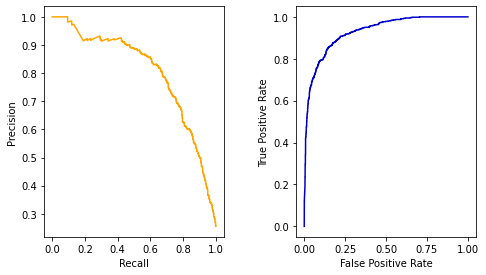

In [41]:
SVM = svm.SVC( probability=True)
s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc = check_scores(SVM,x_train, x_test, y_train, y_test)

**SVM (& TF-IDF) based on the optimization of the hyperparameters** 

In [42]:
# Tuning the hyperparameters
parameters ={
    "C":[0.1,1,10],
    "kernel":['linear', 'rbf', 'sigmoid'],
    "gamma":['scale', 'auto']
}


svm_optimal = grid_search(svm.SVC(probability=True), parameters,x_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   8.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   6.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  10.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  10.2s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   6.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   5.9s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   6.2s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   5.9s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   5.1s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   5.1s
[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=   4.3s
[CV] END ..................C=0.1, gamma=auto, ke

Best parameters are: 

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Train confusion matrix is: 
[[6829   26]
 [   5 1795]]

Test confusion matrix is: 
[[2272   51]
 [ 245  318]]

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2323
           1       0.86      0.56      0.68       563

    accuracy                           0.90      2886
   macro avg       0.88      0.77      0.81      2886
weighted avg       0.89      0.90      0.89      2886


Train accuracy score:  0.996418255343732
Test accuracy score:  0.8974358974358975

Train ROC-AUC score:  0.9987310154793744
Test ROC-AUC score:  0.9287769459624161

Are under Precision-Recall curve: 0.6824034334763949
Area under ROC-AUC: 0.8075700340272364


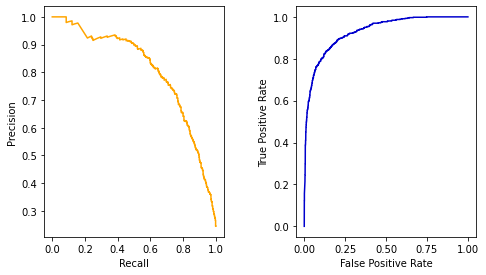

In [44]:
so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc = check_scores(svm_optimal,x_train, x_test, y_train, y_test)


**Multinomial Naive Bayes Classifier**

  Building the Navie Bayes Classifier

Creation of the dictionary (or the bag of words of the data).

To calculate the Navie Bayes Classifier probabilities and then fits the classifier on our training data.

The test data is inputed to this function which determines the sentiment label based of each tweet by using the word counts computed during the training process. Laplace smoothing can be applied while computing Naïve Bayes probabilities for the test data.

Determine how many tweets are classified correctly  (Score) and measures the performance of the model in terms of accuracy.

Train confusion matrix is: 
[[6853    2]
 [1296  504]]

Test confusion matrix is: 
[[2318    5]
 [ 474   89]]

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2323
           1       0.95      0.16      0.27       563

    accuracy                           0.83      2886
   macro avg       0.89      0.58      0.59      2886
weighted avg       0.85      0.83      0.78      2886


Train accuracy score:  0.8500288850375506
Test accuracy score:  0.834026334026334

Train ROC-AUC score:  0.9561105438041981
Test ROC-AUC score:  0.9013005324009118

Are under Precision-Recall curve: 0.2709284627092846
Area under ROC-AUC: 0.7374839454006489


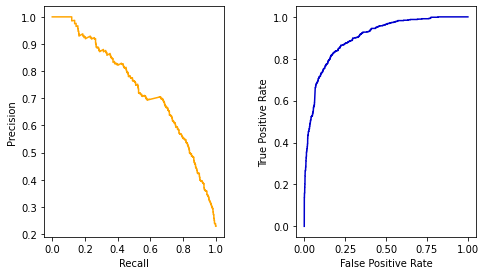

In [45]:
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(MultinomialNB(),x_train, x_test, y_train, y_test)

 **Gaussian Naive Bayes classifier**

Train confusion matrix is: 
[[5543 1312]
 [   0 1800]]

Test confusion matrix is: 
[[1623  700]
 [ 181  382]]

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      2323
           1       0.35      0.68      0.46       563

    accuracy                           0.69      2886
   macro avg       0.63      0.69      0.63      2886
weighted avg       0.79      0.69      0.72      2886


Train accuracy score:  0.8484113229347198
Test accuracy score:  0.6947331947331947

Train ROC-AUC score:  0.9043034281546316
Test ROC-AUC score:  0.688586755810495

Are under Precision-Recall curve: 0.4644376899696049
Area under ROC-AUC: 0.5471372315951626


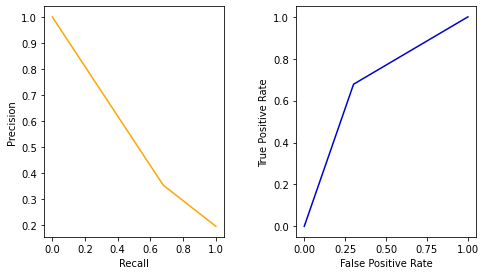

In [46]:
g_train_accuracy, g_test_accuracy, g_train_auc, g_test_auc=check_scores(GaussianNB(),x_train.toarray(), x_test.toarray(), y_train, y_test)

**AdaBoost Classifier**: decision stump!

Train confusion matrix is: 
[[6655  200]
 [1012  788]]

Test confusion matrix is: 
[[2251   72]
 [ 328  235]]

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2323
           1       0.77      0.42      0.54       563

    accuracy                           0.86      2886
   macro avg       0.82      0.69      0.73      2886
weighted avg       0.85      0.86      0.84      2886


Train accuracy score:  0.8599653379549393
Test accuracy score:  0.8613998613998614

Train ROC-AUC score:  0.8689482940270687
Test ROC-AUC score:  0.8373803091947158

Are under Precision-Recall curve: 0.5402298850574713
Area under ROC-AUC: 0.6298876361965743


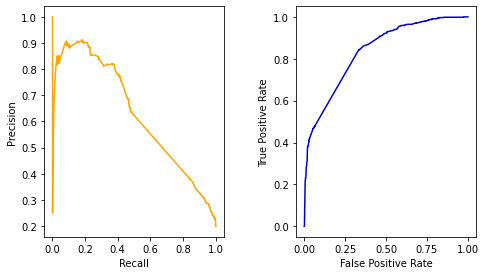

In [47]:
a_train_accuracy, a_test_accuracy, a_train_auc, a_test_auc=check_scores(AdaBoostClassifier(),x_train,x_test, y_train, y_test)

In [48]:
params = {'n_estimators': [10, 50, 100, 500],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
 'algorithm': ['SAMME', 'SAMME.R']}

ada_optimal_model = grid_search(AdaBoostClassifier(), params,x_train, y_train)

Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=10; total time=   0.6s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=10; total time=   0.5s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=50; total time=   2.6s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=50; total time=   2.7s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=100; total time=   2.8s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=100; total time=   2.8s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=500; total time=  13.8s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=500; total time=  13.7s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=10; total time=   0.3s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=10; total time=   0.3s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=50; total time=   1.4s
[CV] END algor

Train confusion matrix is: 
[[6761   94]
 [1043  757]]

Test confusion matrix is: 
[[2278   45]
 [ 340  223]]

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2323
           1       0.83      0.40      0.54       563

    accuracy                           0.87      2886
   macro avg       0.85      0.69      0.73      2886
weighted avg       0.86      0.87      0.85      2886


Train accuracy score:  0.868630849220104
Test accuracy score:  0.8665973665973666

Train ROC-AUC score:  0.9218550936056407
Test ROC-AUC score:  0.8779339205061136

Are under Precision-Recall curve: 0.5367027677496993
Area under ROC-AUC: 0.7021179688268547


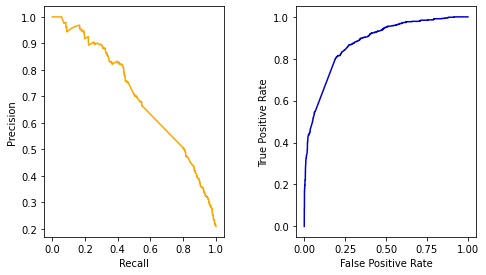

In [49]:
ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc=check_scores(ada_optimal_model,x_train,x_test, y_train, y_test)

**Bagging with MultinomialNB**

Train confusion matrix is: 
[[6853    2]
 [1321  479]]

Test confusion matrix is: 
[[2318    5]
 [ 475   88]]

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2323
           1       0.95      0.16      0.27       563

    accuracy                           0.83      2886
   macro avg       0.89      0.58      0.59      2886
weighted avg       0.85      0.83      0.78      2886


Train accuracy score:  0.8471403812824957
Test accuracy score:  0.8336798336798337

Train ROC-AUC score:  0.9525660102115243
Test ROC-AUC score:  0.8998607637426033

Are under Precision-Recall curve: 0.2682926829268293
Area under ROC-AUC: 0.7339642416509714


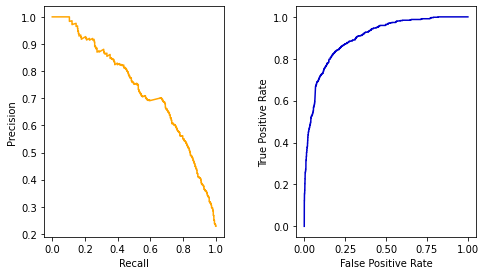

In [50]:
kfold = model_selection.KFold(n_splits = 3)
  
# bagging classifier
model = BaggingClassifier(base_estimator = MultinomialNB(),
                          n_estimators = 100)

b_train_accuracy, b_test_accuracy, b_train_auc, b_test_auc= check_scores(model,x_train,x_test, y_train, y_test)

**Random Forest classifer**

Train confusion matrix is: 
[[6829   26]
 [   5 1795]]

Test confusion matrix is: 
[[2215  108]
 [ 238  325]]

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2323
           1       0.75      0.58      0.65       563

    accuracy                           0.88      2886
   macro avg       0.83      0.77      0.79      2886
weighted avg       0.87      0.88      0.87      2886


Train accuracy score:  0.996418255343732
Test accuracy score:  0.8801108801108801

Train ROC-AUC score:  0.9982442661479861
Test ROC-AUC score:  0.8956867344777572

Are under Precision-Recall curve: 0.6526104417670683
Area under ROC-AUC: 0.7441899264879837


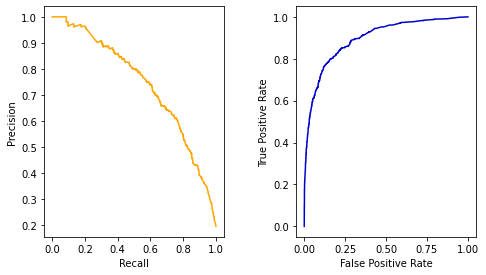

In [51]:
r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc= check_scores(RandomForestClassifier(random_state=0).fit(x_train, y_train), x_train,x_test,y_train,y_test)

Neural Network: **LSTM**

In [64]:
corpus = [df['cleaned_tweet'][i] for i in range( len(df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length=max([len(i) for i in corpus])

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)
    
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(df['airline_sentiment'])
X_final.shape,y_final.shape

((11541, 124), (11541,))

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
121/121 [==============================] - 25s 185ms/step - loss: 0.4583 - accuracy: 0.8090 - val_loss: 0.3335 - val_accuracy: 0.8609
Epoch 2/10
121/121 [==============================] - 22s 178ms/step - loss: 0.2692 - accuracy: 0.8905 - val_loss: 0.2895 - val_accuracy: 0.8858
Epoch 3/10
121/121 [==============================] - 21s 177ms/step - loss: 0.1965 - accuracy: 0.9240 - val_loss: 0.2898 - val_accuracy: 0.8868
Epoch 4/10
121/121 [==============================] - 23s 188ms/step - loss: 0.1597 - accuracy: 0.9368 - val_loss: 0.3345 - val_accuracy: 0.8845
Epoch 5/10
121/121 [==============================] - 30s 245ms/step - loss: 0.1334 - accuracy: 0.9520 - val_loss: 0.3496 - val_accuracy: 0.8800
Epoch 6/10
121/121 [==============================] - 22s 180ms/step - loss: 0.1152 - accuracy: 0.9590 - val_loss: 0.4127 - val_accuracy: 0.8727
Epoch 7/10
121/121 [==============================] - 29s 237ms/step - loss: 0.0989 - accuracy: 0.9656 - val_loss: 0.4207 - val_ac

In [66]:
y_test_pred=model.predict(X_test)
y_train_pred=model.predict(X_train)

In [ ]:
test_acc_lstm = accuracy_score(y_test,y_test_pred)
train_acc_lstm = accuracy_score(y_train,y_train_pred)
test_roc_lstm = roc_auc_score(y_test,y_test_pred)
train_roc_lstm = roc_auc_score(y_train,y_train_pred)

**Bidirectional LSTM**

In [70]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
#from keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
max_len=50

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


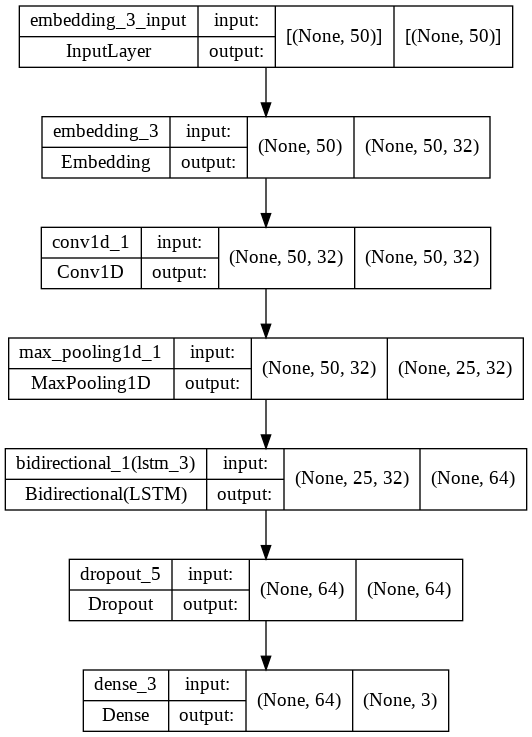

In [71]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_test,y_test),
                      batch_size=batch_size, epochs=epochs, verbose=1)

**Summary**

In [77]:
data = [('Random Forest', r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc),
 ('MultinomialNB',m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc  ),
('Bagged MultinomialNB',b_train_accuracy, b_test_accuracy, b_train_auc, b_test_auc ),
 ('AdaBoost',a_train_accuracy, a_test_accuracy, a_train_auc, a_test_auc ),
('AdaBoost Optimized',ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc),
('Gaussian Naive Bayes',g_train_accuracy, g_test_accuracy, g_train_auc, g_test_auc),
('SVM', s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc),
('SVM Optimized', so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc)
#('LSTM',train_acc_lstm, test_acc_lstm, train_roc_lstm, test_roc_lstm )
       ]


Scores_ =pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy', 'Train ROC', 'Test ROC'])
Scores_.set_index('Model Name', inplace = True)

Scores_

,Train Accuracy,Test Accuracy,Train ROC,Test ROC
Model Name,,,,
Random Forest,0.996418,0.880111,0.998244,0.895687
MultinomialNB,0.850029,0.834026,0.956111,0.901301
Bagged MultinomialNB,0.847140,0.833680,0.952566,0.899861
AdaBoost,0.859965,0.861400,0.868948,0.837380
AdaBoost Optimized,0.868631,0.866597,0.921855,0.877934
Gaussian Naive Bayes,0.848411,0.694733,0.904303,0.688587
SVM,0.978972,0.886348,0.996906,0.929138
SVM Optimized,0.996418,0.897436,0.998731,0.928777


### **4. Splitting the data for Classification**

The data splitting is done in 80-20 split using trian_test_split method of sklearn.

In [ ]:
#splitting the data into 80 and 20 split
train_X, test_X, y_train, y_test = train_test_split(data, labels, test_size=0.2, 
                                                    random_state=42, shuffle=True)

print(f'Number of training examples: {len(train_X)}')
print(f'Number of testing examples: {len(test_X)}')

Number of training examples: 11712
Number of testing examples: 2928


See you with another classifier :)